In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
import rank_measure as rm
import pandas as pd
from tensorflow.keras.layers import Dropout, Dense, Activation
from tensorflow.keras.models import load_model 

In [ ]:
from tensorflow.keras import backend as K
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : 
    # round : 
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # target set 0(Negative) or 1(Positive)
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # Prediction result set 0(Negative) or 1(Positive)

    # True Positive
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) 
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : 
    # round :
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) 
    y_target_yn = K.round(K.clip(y_target, 0, 1)) 

    # True Positive
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) 
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score


In [ ]:
with tf.device('/GPU:0'):
    train_file = np.genfromtxt("hivol-file/hivol-train-all.txt")

In [ ]:
with tf.device('/GPU:0'):
    test_file = np.genfromtxt("hivol-file/hivol-test-all.txt")
    now_file = np.genfromtxt("hivol-file/hivol-now-all.txt")

In [ ]:
print(now_file)

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   2.0000000e+01  2.0191217e+07]
 [-1.0000000e+00  1.0000000e+00  1.0000000e+00 ...  0.0000000e+00
   2.0000000e+01  2.0191218e+07]
 [ 0.0000000e+00 -1.0000000e+00  1.0000000e+00 ...  0.0000000e+00
   2.0000000e+01  2.0191219e+07]
 ...
 [-5.0000000e+00  1.2000000e+01  5.0000000e+00 ...  0.0000000e+00
   6.8000000e+02  2.0200414e+07]
 [ 8.0000000e+00  2.2000000e+01 -1.0000000e+00 ...  0.0000000e+00
   6.8000000e+02  2.0200611e+07]
 [ 6.0000000e+00  9.0000000e+00  8.0000000e+00 ...  0.0000000e+00
   7.6000000e+02  2.0200619e+07]]


In [ ]:
#only indicator feature ex 12 input feature
# cci, rsi, bollinger band, 
print('file loading complete!)
# setting default value
batch_size = 200  # batch size
epochs = 1000
input_size  = 20
target_num = 2

train_x = []
train_y = []
test_x = []
test_y = []
code_arr = []
date_arr = []
vali_x = []
vali_y = []

vali_x2 = []
vali_y2 = []
now_x = []
now_y = []
vali_code_arr = []
vali_date_arr = []
scores = []
predict_code = []
predict_date = []
record_result_info = []
day = []

for line in train_file:
    x = line[:input_size] #
    y = line[input_size:input_size+target_num]
    train_x.append(x)
    train_y.append(y)

for line in test_file:
    x = line[:input_size]
    y = line[input_size:input_size+target_num]
    code = line[input_size+target_num]
    date = line[input_size+target_num+1]
    test_x.append(x)
    test_y.append(y)
    code_arr.append(code)
    date_arr.append(date)

for line in now_file:
    x = line[:input_size]
    y = line[input_size:input_size+target_num]
    code = line[input_size+target_num]
    date = line[input_size+target_num+1]
    vali_x.append(x)
    vali_y.append(y)
    vali_code_arr.append(code)
    vali_date_arr.append(date)
    
train_x = np.array(train_x).reshape(-1, input_size)
test_x = np.array(test_x).reshape(-1, input_size)
vali_x =  np.array(vali_x).reshape(-1, input_size)

train_x = pd.DataFrame(train_x)
test_x = pd.DataFrame(test_x)
vali_x = pd.DataFrame(vali_x)

train_y = pd.DataFrame(train_y)
test_y = pd.DataFrame(test_y)
vali_y =  pd.DataFrame(vali_y)

print('train, test date create sucessfully')

파일 로딩 완료
train, test 파일 분류 완료


In [ ]:
print(len(train_x))
print(len(test_x))
print(len(vali_x))

3410
3391
3303


In [ ]:
#vali data is used fundsimulation (펀심용)
test_len = int(len(test_x)/2)
test_x2= test_x[:test_len]
test_y2 = test_y[:test_len]
now_x = test_x[test_len:]
now_y = test_y[test_len:]

        0     1     2    3     4     5     6    7       8       9      10  \
1695  0.0   0.0   1.0  0.0   0.0   0.0   1.0  0.0  0.6917 -0.2538 -0.0263   
1696  1.0   0.0   0.0 -1.0   0.0   0.0   1.0  0.0  0.8964  0.2133 -0.0657   
1697  3.0   1.0   0.0 -2.0  -1.0   0.0   3.0  1.0  1.1982  0.5699  0.1705   
1698  6.0   3.0   1.0 -5.0  -2.0  -1.0   1.0  0.0  2.2160  1.2822  0.4505   
1699  6.0   6.0   3.0 -3.0  -5.0  -2.0   6.0  2.0  3.6328  2.1007  1.0594   
...   ...   ...   ...  ...   ...   ...   ...  ...     ...     ...     ...   
3386 -5.0   7.0  22.0  7.0  -2.0   0.0   0.0  0.0  6.5697  1.5354  0.5370   
3387 -1.0  14.0   6.0  1.0 -16.0  -6.0   5.0  2.0  4.2139  2.2371  0.8863   
3388 -2.0  -1.0  14.0  2.0   1.0 -16.0   0.0  3.0  3.3824  1.9737  0.7075   
3389  7.0  22.0   5.0 -2.0   0.0  -5.0  16.0  0.0  5.6253  2.4396  0.7239   
3390 -1.0  14.0   6.0  1.0 -16.0  -6.0   5.0  2.0  4.2139  2.2371  0.8863   

           11       12       13       14       15       16        17       

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)

In [ ]:
model = Sequential()
model.add(Dense(input_size, activation='sigmoid', input_shape=(train_x.shape[1],))) # relu 사용 지양
model.add(Dense(50,  activation='sigmoid')) 
model.add(Dropout(0.5))
model.add(Dense(200,  activation='sigmoid')) 
model.add(Dropout(0.5))
model.add(Dense(target_num, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['acc', precision, recall, f1score])
# Fit and evaluate model 
history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=1, 
                    validation_data = (test_x2, test_y2))
#history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=1, 
                    #validation_data = (now_x, now_y), callbacks = [early_stopping])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_13 (Dense)             (None, 50)                1050      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 200)               10200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 402       
Total params: 12,072
Trainable params: 12,072
Non-trainable params: 0
__________________________________________________

3410/3410 [==============================] - 0s 20us/sample - loss: 0.0639 - acc: 0.9326 - precision: 0.9256 - recall: 0.9256 - f1score: 0.9256 - val_loss: 0.0253 - val_acc: 0.9752 - val_precision: 0.9748 - val_recall: 0.9748 - val_f1score: 0.9748
Epoch 28/1000
3410/3410 [==============================] - 0s 21us/sample - loss: 0.0636 - acc: 0.9326 - precision: 0.9308 - recall: 0.9308 - f1score: 0.9308 - val_loss: 0.0249 - val_acc: 0.9752 - val_precision: 0.9736 - val_recall: 0.9736 - val_f1score: 0.9736
Epoch 29/1000
3410/3410 [==============================] - 0s 23us/sample - loss: 0.0634 - acc: 0.9326 - precision: 0.9308 - recall: 0.9308 - f1score: 0.9308 - val_loss: 0.0247 - val_acc: 0.9752 - val_precision: 0.9761 - val_recall: 0.9761 - val_f1score: 0.9761
Epoch 30/1000
3410/3410 [==============================] - 0s 18us/sample - loss: 0.0636 - acc: 0.9326 - precision: 0.9308 - recall: 0.9308 - f1score: 0.9308 - val_loss: 0.0246 - val_acc: 0.9752 - val_precision: 0.9754 - val_rec

3410/3410 [==============================] - 0s 16us/sample - loss: 0.0630 - acc: 0.9326 - precision: 0.9256 - recall: 0.9256 - f1score: 0.9256 - val_loss: 0.0261 - val_acc: 0.9752 - val_precision: 0.9742 - val_recall: 0.9742 - val_f1score: 0.9742
Epoch 59/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0632 - acc: 0.9326 - precision: 0.9361 - recall: 0.9361 - f1score: 0.9361 - val_loss: 0.0247 - val_acc: 0.9752 - val_precision: 0.9748 - val_recall: 0.9748 - val_f1score: 0.9748
Epoch 60/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0626 - acc: 0.9326 - precision: 0.9361 - recall: 0.9361 - f1score: 0.9361 - val_loss: 0.0248 - val_acc: 0.9752 - val_precision: 0.9748 - val_recall: 0.9748 - val_f1score: 0.9748
Epoch 61/1000
3410/3410 [==============================] - 0s 15us/sample - loss: 0.0629 - acc: 0.9326 - precision: 0.9256 - recall: 0.9256 - f1score: 0.9256 - val_loss: 0.0261 - val_acc: 0.9752 - val_precision: 0.9761 - val_rec

3410/3410 [==============================] - 0s 15us/sample - loss: 0.0608 - acc: 0.9326 - precision: 0.9308 - recall: 0.9308 - f1score: 0.9308 - val_loss: 0.0259 - val_acc: 0.9752 - val_precision: 0.9754 - val_recall: 0.9754 - val_f1score: 0.9754
Epoch 90/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0610 - acc: 0.9326 - precision: 0.9361 - recall: 0.9361 - f1score: 0.9361 - val_loss: 0.0251 - val_acc: 0.9752 - val_precision: 0.9748 - val_recall: 0.9748 - val_f1score: 0.9748
Epoch 91/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0608 - acc: 0.9334 - precision: 0.9367 - recall: 0.9369 - f1score: 0.9368 - val_loss: 0.0250 - val_acc: 0.9752 - val_precision: 0.9730 - val_recall: 0.9730 - val_f1score: 0.9730
Epoch 92/1000
3410/3410 [==============================] - 0s 18us/sample - loss: 0.0606 - acc: 0.9323 - precision: 0.9303 - recall: 0.9306 - f1score: 0.9304 - val_loss: 0.0257 - val_acc: 0.9752 - val_precision: 0.9748 - val_rec

3410/3410 [==============================] - 0s 17us/sample - loss: 0.0583 - acc: 0.9352 - precision: 0.9331 - recall: 0.9333 - f1score: 0.9332 - val_loss: 0.0260 - val_acc: 0.9752 - val_precision: 0.9767 - val_recall: 0.9767 - val_f1score: 0.9767
Epoch 121/1000
3410/3410 [==============================] - 0s 17us/sample - loss: 0.0596 - acc: 0.9334 - precision: 0.9266 - recall: 0.9261 - f1score: 0.9264 - val_loss: 0.0255 - val_acc: 0.9752 - val_precision: 0.9767 - val_recall: 0.9767 - val_f1score: 0.9767
Epoch 122/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0590 - acc: 0.9340 - precision: 0.9375 - recall: 0.9375 - f1score: 0.9375 - val_loss: 0.0252 - val_acc: 0.9752 - val_precision: 0.9736 - val_recall: 0.9736 - val_f1score: 0.9736
Epoch 123/1000
3410/3410 [==============================] - 0s 18us/sample - loss: 0.0589 - acc: 0.9361 - precision: 0.9334 - recall: 0.9342 - f1score: 0.9338 - val_loss: 0.0258 - val_acc: 0.9752 - val_precision: 0.9754 - val_

Epoch 151/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0570 - acc: 0.9370 - precision: 0.9350 - recall: 0.9350 - f1score: 0.9350 - val_loss: 0.0262 - val_acc: 0.9729 - val_precision: 0.9726 - val_recall: 0.9726 - val_f1score: 0.9726
Epoch 152/1000
3410/3410 [==============================] - 0s 15us/sample - loss: 0.0574 - acc: 0.9381 - precision: 0.9408 - recall: 0.9403 - f1score: 0.9405 - val_loss: 0.0253 - val_acc: 0.9752 - val_precision: 0.9748 - val_recall: 0.9748 - val_f1score: 0.9748
Epoch 153/1000
3410/3410 [==============================] - 0s 15us/sample - loss: 0.0566 - acc: 0.9378 - precision: 0.9411 - recall: 0.9414 - f1score: 0.9413 - val_loss: 0.0263 - val_acc: 0.9723 - val_precision: 0.9739 - val_recall: 0.9739 - val_f1score: 0.9739
Epoch 154/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0572 - acc: 0.9355 - precision: 0.9391 - recall: 0.9389 - f1score: 0.9390 - val_loss: 0.0265 - val_acc: 0.9723 - val_precision

3410/3410 [==============================] - 0s 15us/sample - loss: 0.0561 - acc: 0.9378 - precision: 0.9413 - recall: 0.9406 - f1score: 0.9409 - val_loss: 0.0262 - val_acc: 0.9723 - val_precision: 0.9720 - val_recall: 0.9720 - val_f1score: 0.9720
Epoch 183/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0564 - acc: 0.9384 - precision: 0.9367 - recall: 0.9364 - f1score: 0.9365 - val_loss: 0.0272 - val_acc: 0.9723 - val_precision: 0.9727 - val_recall: 0.9727 - val_f1score: 0.9727
Epoch 184/1000
3410/3410 [==============================] - 0s 18us/sample - loss: 0.0565 - acc: 0.9370 - precision: 0.9403 - recall: 0.9406 - f1score: 0.9404 - val_loss: 0.0268 - val_acc: 0.9723 - val_precision: 0.9720 - val_recall: 0.9720 - val_f1score: 0.9720
Epoch 185/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0559 - acc: 0.9393 - precision: 0.9428 - recall: 0.9431 - f1score: 0.9429 - val_loss: 0.0264 - val_acc: 0.9723 - val_precision: 0.9727 - val_

3410/3410 [==============================] - 0s 16us/sample - loss: 0.0555 - acc: 0.9405 - precision: 0.9439 - recall: 0.9439 - f1score: 0.9439 - val_loss: 0.0267 - val_acc: 0.9723 - val_precision: 0.9720 - val_recall: 0.9720 - val_f1score: 0.9720
Epoch 214/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0562 - acc: 0.9378 - precision: 0.9356 - recall: 0.9358 - f1score: 0.9357 - val_loss: 0.0269 - val_acc: 0.9723 - val_precision: 0.9720 - val_recall: 0.9720 - val_f1score: 0.9720
Epoch 215/1000
3410/3410 [==============================] - 0s 17us/sample - loss: 0.0546 - acc: 0.9408 - precision: 0.9384 - recall: 0.9386 - f1score: 0.9385 - val_loss: 0.0274 - val_acc: 0.9723 - val_precision: 0.9727 - val_recall: 0.9727 - val_f1score: 0.9727
Epoch 216/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0559 - acc: 0.9370 - precision: 0.9350 - recall: 0.9350 - f1score: 0.9350 - val_loss: 0.0274 - val_acc: 0.9723 - val_precision: 0.9720 - val_

3410/3410 [==============================] - 0s 16us/sample - loss: 0.0543 - acc: 0.9405 - precision: 0.9433 - recall: 0.9436 - f1score: 0.9435 - val_loss: 0.0265 - val_acc: 0.9735 - val_precision: 0.9725 - val_recall: 0.9725 - val_f1score: 0.9725
Epoch 245/1000
3410/3410 [==============================] - 0s 17us/sample - loss: 0.0556 - acc: 0.9390 - precision: 0.9420 - recall: 0.9425 - f1score: 0.9422 - val_loss: 0.0271 - val_acc: 0.9729 - val_precision: 0.9732 - val_recall: 0.9732 - val_f1score: 0.9732
Epoch 246/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0558 - acc: 0.9384 - precision: 0.9364 - recall: 0.9364 - f1score: 0.9364 - val_loss: 0.0276 - val_acc: 0.9723 - val_precision: 0.9727 - val_recall: 0.9727 - val_f1score: 0.9727
Epoch 247/1000
3410/3410 [==============================] - 0s 17us/sample - loss: 0.0550 - acc: 0.9402 - precision: 0.9375 - recall: 0.9381 - f1score: 0.9378 - val_loss: 0.0267 - val_acc: 0.9729 - val_precision: 0.9720 - val_

3410/3410 [==============================] - 0s 16us/sample - loss: 0.0548 - acc: 0.9399 - precision: 0.9431 - recall: 0.9431 - f1score: 0.9431 - val_loss: 0.0267 - val_acc: 0.9735 - val_precision: 0.9744 - val_recall: 0.9744 - val_f1score: 0.9744
Epoch 276/1000
3410/3410 [==============================] - 0s 15us/sample - loss: 0.0547 - acc: 0.9393 - precision: 0.9425 - recall: 0.9428 - f1score: 0.9427 - val_loss: 0.0271 - val_acc: 0.9729 - val_precision: 0.9738 - val_recall: 0.9738 - val_f1score: 0.9738
Epoch 277/1000
3410/3410 [==============================] - 0s 15us/sample - loss: 0.0544 - acc: 0.9402 - precision: 0.9433 - recall: 0.9431 - f1score: 0.9432 - val_loss: 0.0266 - val_acc: 0.9735 - val_precision: 0.9732 - val_recall: 0.9732 - val_f1score: 0.9732
Epoch 278/1000
3410/3410 [==============================] - 0s 15us/sample - loss: 0.0541 - acc: 0.9405 - precision: 0.9433 - recall: 0.9433 - f1score: 0.9433 - val_loss: 0.0269 - val_acc: 0.9729 - val_precision: 0.9726 - val_

3410/3410 [==============================] - 0s 15us/sample - loss: 0.0541 - acc: 0.9399 - precision: 0.9325 - recall: 0.9325 - f1score: 0.9325 - val_loss: 0.0277 - val_acc: 0.9723 - val_precision: 0.9702 - val_recall: 0.9702 - val_f1score: 0.9702
Epoch 307/1000
3410/3410 [==============================] - 0s 15us/sample - loss: 0.0536 - acc: 0.9411 - precision: 0.9389 - recall: 0.9386 - f1score: 0.9387 - val_loss: 0.0270 - val_acc: 0.9729 - val_precision: 0.9708 - val_recall: 0.9708 - val_f1score: 0.9708
Epoch 308/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0544 - acc: 0.9399 - precision: 0.9431 - recall: 0.9433 - f1score: 0.9432 - val_loss: 0.0268 - val_acc: 0.9729 - val_precision: 0.9744 - val_recall: 0.9744 - val_f1score: 0.9744
Epoch 309/1000
3410/3410 [==============================] - 0s 17us/sample - loss: 0.0528 - acc: 0.9434 - precision: 0.9469 - recall: 0.9464 - f1score: 0.9466 - val_loss: 0.0277 - val_acc: 0.9723 - val_precision: 0.9714 - val_

3410/3410 [==============================] - 0s 17us/sample - loss: 0.0524 - acc: 0.9425 - precision: 0.9403 - recall: 0.9403 - f1score: 0.9403 - val_loss: 0.0279 - val_acc: 0.9723 - val_precision: 0.9739 - val_recall: 0.9739 - val_f1score: 0.9739
Epoch 338/1000
3410/3410 [==============================] - 0s 15us/sample - loss: 0.0530 - acc: 0.9405 - precision: 0.9436 - recall: 0.9439 - f1score: 0.9438 - val_loss: 0.0273 - val_acc: 0.9723 - val_precision: 0.9720 - val_recall: 0.9720 - val_f1score: 0.9720
Epoch 339/1000
3410/3410 [==============================] - 0s 15us/sample - loss: 0.0528 - acc: 0.9425 - precision: 0.9350 - recall: 0.9353 - f1score: 0.9351 - val_loss: 0.0288 - val_acc: 0.9717 - val_precision: 0.9721 - val_recall: 0.9721 - val_f1score: 0.9721
Epoch 340/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0523 - acc: 0.9422 - precision: 0.9450 - recall: 0.9456 - f1score: 0.9453 - val_loss: 0.0275 - val_acc: 0.9723 - val_precision: 0.9727 - val_

3410/3410 [==============================] - 0s 16us/sample - loss: 0.0512 - acc: 0.9437 - precision: 0.9414 - recall: 0.9414 - f1score: 0.9414 - val_loss: 0.0285 - val_acc: 0.9711 - val_precision: 0.9697 - val_recall: 0.9697 - val_f1score: 0.9697
Epoch 369/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0524 - acc: 0.9416 - precision: 0.9397 - recall: 0.9394 - f1score: 0.9396 - val_loss: 0.0296 - val_acc: 0.9705 - val_precision: 0.9692 - val_recall: 0.9692 - val_f1score: 0.9692
Epoch 370/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0520 - acc: 0.9434 - precision: 0.9464 - recall: 0.9461 - f1score: 0.9462 - val_loss: 0.0282 - val_acc: 0.9711 - val_precision: 0.9709 - val_recall: 0.9709 - val_f1score: 0.9709
Epoch 371/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0513 - acc: 0.9446 - precision: 0.9425 - recall: 0.9422 - f1score: 0.9424 - val_loss: 0.0286 - val_acc: 0.9711 - val_precision: 0.9728 - val_

3410/3410 [==============================] - 0s 16us/sample - loss: 0.0512 - acc: 0.9428 - precision: 0.9353 - recall: 0.9356 - f1score: 0.9354 - val_loss: 0.0292 - val_acc: 0.9699 - val_precision: 0.9698 - val_recall: 0.9698 - val_f1score: 0.9698
Epoch 400/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0519 - acc: 0.9431 - precision: 0.9461 - recall: 0.9461 - f1score: 0.9461 - val_loss: 0.0287 - val_acc: 0.9711 - val_precision: 0.9722 - val_recall: 0.9722 - val_f1score: 0.9722
Epoch 401/1000
3410/3410 [==============================] - 0s 15us/sample - loss: 0.0512 - acc: 0.9443 - precision: 0.9419 - recall: 0.9419 - f1score: 0.9419 - val_loss: 0.0292 - val_acc: 0.9699 - val_precision: 0.9698 - val_recall: 0.9698 - val_f1score: 0.9698
Epoch 402/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0510 - acc: 0.9437 - precision: 0.9364 - recall: 0.9361 - f1score: 0.9362 - val_loss: 0.0292 - val_acc: 0.9705 - val_precision: 0.9698 - val_

3410/3410 [==============================] - 0s 15us/sample - loss: 0.0496 - acc: 0.9452 - precision: 0.9481 - recall: 0.9481 - f1score: 0.9481 - val_loss: 0.0288 - val_acc: 0.9711 - val_precision: 0.9722 - val_recall: 0.9722 - val_f1score: 0.9722
Epoch 431/1000
3410/3410 [==============================] - 0s 15us/sample - loss: 0.0504 - acc: 0.9452 - precision: 0.9480 - recall: 0.9478 - f1score: 0.9479 - val_loss: 0.0290 - val_acc: 0.9705 - val_precision: 0.9692 - val_recall: 0.9692 - val_f1score: 0.9692
Epoch 432/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0497 - acc: 0.9457 - precision: 0.9433 - recall: 0.9433 - f1score: 0.9433 - val_loss: 0.0292 - val_acc: 0.9711 - val_precision: 0.9715 - val_recall: 0.9715 - val_f1score: 0.9715
Epoch 433/1000
3410/3410 [==============================] - 0s 15us/sample - loss: 0.0495 - acc: 0.9455 - precision: 0.9483 - recall: 0.9483 - f1score: 0.9483 - val_loss: 0.0293 - val_acc: 0.9705 - val_precision: 0.9698 - val_

Epoch 461/1000
3410/3410 [==============================] - 0s 22us/sample - loss: 0.0497 - acc: 0.9457 - precision: 0.9433 - recall: 0.9431 - f1score: 0.9432 - val_loss: 0.0314 - val_acc: 0.9670 - val_precision: 0.9670 - val_recall: 0.9670 - val_f1score: 0.9670
Epoch 462/1000
3410/3410 [==============================] - 0s 18us/sample - loss: 0.0497 - acc: 0.9455 - precision: 0.9483 - recall: 0.9483 - f1score: 0.9483 - val_loss: 0.0302 - val_acc: 0.9693 - val_precision: 0.9693 - val_recall: 0.9693 - val_f1score: 0.9693
Epoch 463/1000
3410/3410 [==============================] - 0s 21us/sample - loss: 0.0497 - acc: 0.9452 - precision: 0.9481 - recall: 0.9481 - f1score: 0.9481 - val_loss: 0.0296 - val_acc: 0.9699 - val_precision: 0.9692 - val_recall: 0.9692 - val_f1score: 0.9692
Epoch 464/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0497 - acc: 0.9460 - precision: 0.9436 - recall: 0.9436 - f1score: 0.9436 - val_loss: 0.0303 - val_acc: 0.9687 - val_precision

3410/3410 [==============================] - 0s 17us/sample - loss: 0.0485 - acc: 0.9469 - precision: 0.9497 - recall: 0.9497 - f1score: 0.9497 - val_loss: 0.0300 - val_acc: 0.9699 - val_precision: 0.9711 - val_recall: 0.9711 - val_f1score: 0.9711
Epoch 493/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0496 - acc: 0.9457 - precision: 0.9486 - recall: 0.9486 - f1score: 0.9486 - val_loss: 0.0296 - val_acc: 0.9699 - val_precision: 0.9711 - val_recall: 0.9711 - val_f1score: 0.9711
Epoch 494/1000
3410/3410 [==============================] - 0s 17us/sample - loss: 0.0482 - acc: 0.9475 - precision: 0.9450 - recall: 0.9450 - f1score: 0.9450 - val_loss: 0.0310 - val_acc: 0.9681 - val_precision: 0.9675 - val_recall: 0.9675 - val_f1score: 0.9675
Epoch 495/1000
3410/3410 [==============================] - 0s 15us/sample - loss: 0.0488 - acc: 0.9457 - precision: 0.9436 - recall: 0.9433 - f1score: 0.9435 - val_loss: 0.0305 - val_acc: 0.9681 - val_precision: 0.9682 - val_

3410/3410 [==============================] - 0s 16us/sample - loss: 0.0491 - acc: 0.9460 - precision: 0.9486 - recall: 0.9489 - f1score: 0.9488 - val_loss: 0.0308 - val_acc: 0.9693 - val_precision: 0.9693 - val_recall: 0.9693 - val_f1score: 0.9693
Epoch 524/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0482 - acc: 0.9475 - precision: 0.9450 - recall: 0.9450 - f1score: 0.9450 - val_loss: 0.0318 - val_acc: 0.9681 - val_precision: 0.9682 - val_recall: 0.9682 - val_f1score: 0.9682
Epoch 525/1000
3410/3410 [==============================] - 0s 15us/sample - loss: 0.0481 - acc: 0.9466 - precision: 0.9494 - recall: 0.9494 - f1score: 0.9494 - val_loss: 0.0310 - val_acc: 0.9687 - val_precision: 0.9693 - val_recall: 0.9693 - val_f1score: 0.9693
Epoch 526/1000
3410/3410 [==============================] - 0s 15us/sample - loss: 0.0483 - acc: 0.9466 - precision: 0.9492 - recall: 0.9497 - f1score: 0.9495 - val_loss: 0.0303 - val_acc: 0.9693 - val_precision: 0.9693 - val_

3410/3410 [==============================] - 0s 16us/sample - loss: 0.0486 - acc: 0.9469 - precision: 0.9444 - recall: 0.9444 - f1score: 0.9444 - val_loss: 0.0306 - val_acc: 0.9693 - val_precision: 0.9699 - val_recall: 0.9699 - val_f1score: 0.9699
Epoch 555/1000
3410/3410 [==============================] - 0s 17us/sample - loss: 0.0487 - acc: 0.9478 - precision: 0.9506 - recall: 0.9506 - f1score: 0.9506 - val_loss: 0.0304 - val_acc: 0.9693 - val_precision: 0.9705 - val_recall: 0.9705 - val_f1score: 0.9705
Epoch 556/1000
3410/3410 [==============================] - 0s 15us/sample - loss: 0.0480 - acc: 0.9463 - precision: 0.9492 - recall: 0.9492 - f1score: 0.9492 - val_loss: 0.0302 - val_acc: 0.9699 - val_precision: 0.9704 - val_recall: 0.9704 - val_f1score: 0.9704
Epoch 557/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0481 - acc: 0.9478 - precision: 0.9505 - recall: 0.9503 - f1score: 0.9504 - val_loss: 0.0306 - val_acc: 0.9693 - val_precision: 0.9705 - val_

3410/3410 [==============================] - 0s 16us/sample - loss: 0.0476 - acc: 0.9481 - precision: 0.9508 - recall: 0.9506 - f1score: 0.9507 - val_loss: 0.0313 - val_acc: 0.9687 - val_precision: 0.9669 - val_recall: 0.9669 - val_f1score: 0.9669
Epoch 586/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0474 - acc: 0.9478 - precision: 0.9506 - recall: 0.9506 - f1score: 0.9506 - val_loss: 0.0312 - val_acc: 0.9687 - val_precision: 0.9681 - val_recall: 0.9681 - val_f1score: 0.9681
Epoch 587/1000
3410/3410 [==============================] - 0s 15us/sample - loss: 0.0464 - acc: 0.9501 - precision: 0.9475 - recall: 0.9475 - f1score: 0.9475 - val_loss: 0.0311 - val_acc: 0.9687 - val_precision: 0.9687 - val_recall: 0.9687 - val_f1score: 0.9687
Epoch 588/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0469 - acc: 0.9487 - precision: 0.9408 - recall: 0.9408 - f1score: 0.9408 - val_loss: 0.0322 - val_acc: 0.9681 - val_precision: 0.9682 - val_

3410/3410 [==============================] - 0s 15us/sample - loss: 0.0465 - acc: 0.9499 - precision: 0.9472 - recall: 0.9472 - f1score: 0.9472 - val_loss: 0.0311 - val_acc: 0.9687 - val_precision: 0.9687 - val_recall: 0.9687 - val_f1score: 0.9687
Epoch 617/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0473 - acc: 0.9481 - precision: 0.9511 - recall: 0.9508 - f1score: 0.9510 - val_loss: 0.0312 - val_acc: 0.9687 - val_precision: 0.9681 - val_recall: 0.9681 - val_f1score: 0.9681
Epoch 618/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0466 - acc: 0.9487 - precision: 0.9461 - recall: 0.9461 - f1score: 0.9461 - val_loss: 0.0310 - val_acc: 0.9693 - val_precision: 0.9687 - val_recall: 0.9687 - val_f1score: 0.9687
Epoch 619/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0471 - acc: 0.9493 - precision: 0.9520 - recall: 0.9522 - f1score: 0.9521 - val_loss: 0.0310 - val_acc: 0.9687 - val_precision: 0.9656 - val_

3410/3410 [==============================] - 0s 16us/sample - loss: 0.0466 - acc: 0.9501 - precision: 0.9528 - recall: 0.9528 - f1score: 0.9528 - val_loss: 0.0313 - val_acc: 0.9693 - val_precision: 0.9699 - val_recall: 0.9699 - val_f1score: 0.9699
Epoch 648/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0466 - acc: 0.9504 - precision: 0.9528 - recall: 0.9531 - f1score: 0.9529 - val_loss: 0.0313 - val_acc: 0.9687 - val_precision: 0.9699 - val_recall: 0.9699 - val_f1score: 0.9699
Epoch 649/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0464 - acc: 0.9496 - precision: 0.9364 - recall: 0.9364 - f1score: 0.9364 - val_loss: 0.0312 - val_acc: 0.9693 - val_precision: 0.9693 - val_recall: 0.9693 - val_f1score: 0.9693
Epoch 650/1000
3410/3410 [==============================] - 0s 15us/sample - loss: 0.0469 - acc: 0.9487 - precision: 0.9461 - recall: 0.9461 - f1score: 0.9461 - val_loss: 0.0323 - val_acc: 0.9681 - val_precision: 0.9694 - val_

3410/3410 [==============================] - 0s 16us/sample - loss: 0.0464 - acc: 0.9499 - precision: 0.9419 - recall: 0.9419 - f1score: 0.9419 - val_loss: 0.0331 - val_acc: 0.9670 - val_precision: 0.9677 - val_recall: 0.9677 - val_f1score: 0.9677
Epoch 679/1000
3410/3410 [==============================] - 0s 17us/sample - loss: 0.0467 - acc: 0.9487 - precision: 0.9514 - recall: 0.9517 - f1score: 0.9515 - val_loss: 0.0314 - val_acc: 0.9687 - val_precision: 0.9687 - val_recall: 0.9687 - val_f1score: 0.9687
Epoch 680/1000
3410/3410 [==============================] - 0s 23us/sample - loss: 0.0458 - acc: 0.9496 - precision: 0.9522 - recall: 0.9522 - f1score: 0.9522 - val_loss: 0.0311 - val_acc: 0.9699 - val_precision: 0.9711 - val_recall: 0.9711 - val_f1score: 0.9711
Epoch 681/1000
3410/3410 [==============================] - 0s 19us/sample - loss: 0.0452 - acc: 0.9516 - precision: 0.9489 - recall: 0.9489 - f1score: 0.9489 - val_loss: 0.0311 - val_acc: 0.9693 - val_precision: 0.9687 - val_

3410/3410 [==============================] - 0s 16us/sample - loss: 0.0459 - acc: 0.9501 - precision: 0.9528 - recall: 0.9528 - f1score: 0.9528 - val_loss: 0.0321 - val_acc: 0.9670 - val_precision: 0.9664 - val_recall: 0.9664 - val_f1score: 0.9664
Epoch 710/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0451 - acc: 0.9513 - precision: 0.9539 - recall: 0.9539 - f1score: 0.9539 - val_loss: 0.0313 - val_acc: 0.9693 - val_precision: 0.9680 - val_recall: 0.9680 - val_f1score: 0.9680
Epoch 711/1000
3410/3410 [==============================] - 0s 17us/sample - loss: 0.0453 - acc: 0.9510 - precision: 0.9536 - recall: 0.9536 - f1score: 0.9536 - val_loss: 0.0321 - val_acc: 0.9658 - val_precision: 0.9647 - val_recall: 0.9647 - val_f1score: 0.9647
Epoch 712/1000
3410/3410 [==============================] - 0s 17us/sample - loss: 0.0459 - acc: 0.9504 - precision: 0.9531 - recall: 0.9531 - f1score: 0.9531 - val_loss: 0.0307 - val_acc: 0.9693 - val_precision: 0.9705 - val_

3410/3410 [==============================] - 0s 18us/sample - loss: 0.0457 - acc: 0.9510 - precision: 0.9536 - recall: 0.9536 - f1score: 0.9536 - val_loss: 0.0313 - val_acc: 0.9687 - val_precision: 0.9699 - val_recall: 0.9699 - val_f1score: 0.9699
Epoch 741/1000
3410/3410 [==============================] - 0s 17us/sample - loss: 0.0456 - acc: 0.9510 - precision: 0.9536 - recall: 0.9536 - f1score: 0.9536 - val_loss: 0.0314 - val_acc: 0.9681 - val_precision: 0.9682 - val_recall: 0.9682 - val_f1score: 0.9682
Epoch 742/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0447 - acc: 0.9516 - precision: 0.9541 - recall: 0.9539 - f1score: 0.9540 - val_loss: 0.0305 - val_acc: 0.9693 - val_precision: 0.9674 - val_recall: 0.9674 - val_f1score: 0.9674
Epoch 743/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0448 - acc: 0.9516 - precision: 0.9489 - recall: 0.9492 - f1score: 0.9490 - val_loss: 0.0327 - val_acc: 0.9664 - val_precision: 0.9671 - val_

3410/3410 [==============================] - 0s 16us/sample - loss: 0.0443 - acc: 0.9522 - precision: 0.9547 - recall: 0.9547 - f1score: 0.9547 - val_loss: 0.0298 - val_acc: 0.9699 - val_precision: 0.9711 - val_recall: 0.9711 - val_f1score: 0.9711
Epoch 772/1000
3410/3410 [==============================] - 0s 17us/sample - loss: 0.0451 - acc: 0.9516 - precision: 0.9542 - recall: 0.9539 - f1score: 0.9540 - val_loss: 0.0303 - val_acc: 0.9693 - val_precision: 0.9705 - val_recall: 0.9705 - val_f1score: 0.9705
Epoch 773/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0444 - acc: 0.9519 - precision: 0.9544 - recall: 0.9544 - f1score: 0.9544 - val_loss: 0.0306 - val_acc: 0.9693 - val_precision: 0.9705 - val_recall: 0.9705 - val_f1score: 0.9705
Epoch 774/1000
3410/3410 [==============================] - 0s 17us/sample - loss: 0.0437 - acc: 0.9534 - precision: 0.9558 - recall: 0.9558 - f1score: 0.9558 - val_loss: 0.0301 - val_acc: 0.9693 - val_precision: 0.9687 - val_

3410/3410 [==============================] - 0s 18us/sample - loss: 0.0446 - acc: 0.9516 - precision: 0.9542 - recall: 0.9542 - f1score: 0.9542 - val_loss: 0.0308 - val_acc: 0.9693 - val_precision: 0.9687 - val_recall: 0.9687 - val_f1score: 0.9687
Epoch 803/1000
3410/3410 [==============================] - 0s 18us/sample - loss: 0.0454 - acc: 0.9507 - precision: 0.9533 - recall: 0.9533 - f1score: 0.9533 - val_loss: 0.0312 - val_acc: 0.9670 - val_precision: 0.9670 - val_recall: 0.9670 - val_f1score: 0.9670
Epoch 804/1000
3410/3410 [==============================] - 0s 18us/sample - loss: 0.0444 - acc: 0.9522 - precision: 0.9494 - recall: 0.9494 - f1score: 0.9494 - val_loss: 0.0312 - val_acc: 0.9681 - val_precision: 0.9675 - val_recall: 0.9675 - val_f1score: 0.9675
Epoch 805/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0449 - acc: 0.9510 - precision: 0.9536 - recall: 0.9536 - f1score: 0.9536 - val_loss: 0.0305 - val_acc: 0.9693 - val_precision: 0.9699 - val_

3410/3410 [==============================] - 0s 15us/sample - loss: 0.0452 - acc: 0.9507 - precision: 0.9533 - recall: 0.9533 - f1score: 0.9533 - val_loss: 0.0311 - val_acc: 0.9687 - val_precision: 0.9687 - val_recall: 0.9687 - val_f1score: 0.9687
Epoch 834/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0443 - acc: 0.9522 - precision: 0.9442 - recall: 0.9442 - f1score: 0.9442 - val_loss: 0.0317 - val_acc: 0.9676 - val_precision: 0.9670 - val_recall: 0.9670 - val_f1score: 0.9670
Epoch 835/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0442 - acc: 0.9531 - precision: 0.9556 - recall: 0.9556 - f1score: 0.9556 - val_loss: 0.0314 - val_acc: 0.9681 - val_precision: 0.9669 - val_recall: 0.9669 - val_f1score: 0.9669
Epoch 836/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0444 - acc: 0.9516 - precision: 0.9489 - recall: 0.9489 - f1score: 0.9489 - val_loss: 0.0324 - val_acc: 0.9658 - val_precision: 0.9653 - val_

3410/3410 [==============================] - 0s 16us/sample - loss: 0.0444 - acc: 0.9522 - precision: 0.9547 - recall: 0.9547 - f1score: 0.9547 - val_loss: 0.0312 - val_acc: 0.9676 - val_precision: 0.9682 - val_recall: 0.9682 - val_f1score: 0.9682
Epoch 865/1000
3410/3410 [==============================] - 0s 19us/sample - loss: 0.0437 - acc: 0.9537 - precision: 0.9456 - recall: 0.9456 - f1score: 0.9456 - val_loss: 0.0324 - val_acc: 0.9664 - val_precision: 0.9665 - val_recall: 0.9665 - val_f1score: 0.9665
Epoch 866/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0445 - acc: 0.9525 - precision: 0.9550 - recall: 0.9550 - f1score: 0.9550 - val_loss: 0.0309 - val_acc: 0.9676 - val_precision: 0.9694 - val_recall: 0.9694 - val_f1score: 0.9694
Epoch 867/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0441 - acc: 0.9522 - precision: 0.9547 - recall: 0.9547 - f1score: 0.9547 - val_loss: 0.0308 - val_acc: 0.9676 - val_precision: 0.9688 - val_

3410/3410 [==============================] - 0s 16us/sample - loss: 0.0439 - acc: 0.9534 - precision: 0.9558 - recall: 0.9558 - f1score: 0.9558 - val_loss: 0.0320 - val_acc: 0.9652 - val_precision: 0.9648 - val_recall: 0.9648 - val_f1score: 0.9648
Epoch 896/1000
3410/3410 [==============================] - 0s 18us/sample - loss: 0.0430 - acc: 0.9548 - precision: 0.9519 - recall: 0.9519 - f1score: 0.9519 - val_loss: 0.0320 - val_acc: 0.9658 - val_precision: 0.9647 - val_recall: 0.9647 - val_f1score: 0.9647
Epoch 897/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0437 - acc: 0.9537 - precision: 0.9558 - recall: 0.9561 - f1score: 0.9560 - val_loss: 0.0322 - val_acc: 0.9670 - val_precision: 0.9670 - val_recall: 0.9670 - val_f1score: 0.9670
Epoch 898/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0437 - acc: 0.9528 - precision: 0.9553 - recall: 0.9553 - f1score: 0.9553 - val_loss: 0.0317 - val_acc: 0.9664 - val_precision: 0.9665 - val_

3410/3410 [==============================] - 0s 15us/sample - loss: 0.0432 - acc: 0.9534 - precision: 0.9558 - recall: 0.9561 - f1score: 0.9560 - val_loss: 0.0328 - val_acc: 0.9658 - val_precision: 0.9672 - val_recall: 0.9672 - val_f1score: 0.9672
Epoch 926/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0438 - acc: 0.9534 - precision: 0.9558 - recall: 0.9558 - f1score: 0.9558 - val_loss: 0.0313 - val_acc: 0.9687 - val_precision: 0.9675 - val_recall: 0.9675 - val_f1score: 0.9675
Epoch 927/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0438 - acc: 0.9522 - precision: 0.9547 - recall: 0.9547 - f1score: 0.9547 - val_loss: 0.0318 - val_acc: 0.9681 - val_precision: 0.9688 - val_recall: 0.9688 - val_f1score: 0.9688
Epoch 928/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0435 - acc: 0.9534 - precision: 0.9558 - recall: 0.9558 - f1score: 0.9558 - val_loss: 0.0315 - val_acc: 0.9687 - val_precision: 0.9681 - val_

3410/3410 [==============================] - 0s 16us/sample - loss: 0.0434 - acc: 0.9537 - precision: 0.9508 - recall: 0.9511 - f1score: 0.9510 - val_loss: 0.0334 - val_acc: 0.9652 - val_precision: 0.9642 - val_recall: 0.9642 - val_f1score: 0.9642
Epoch 957/1000
3410/3410 [==============================] - 0s 17us/sample - loss: 0.0422 - acc: 0.9540 - precision: 0.9511 - recall: 0.9508 - f1score: 0.9510 - val_loss: 0.0339 - val_acc: 0.9646 - val_precision: 0.9642 - val_recall: 0.9642 - val_f1score: 0.9642
Epoch 958/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0423 - acc: 0.9548 - precision: 0.9572 - recall: 0.9572 - f1score: 0.9572 - val_loss: 0.0330 - val_acc: 0.9664 - val_precision: 0.9653 - val_recall: 0.9653 - val_f1score: 0.9653
Epoch 959/1000
3410/3410 [==============================] - 0s 17us/sample - loss: 0.0430 - acc: 0.9537 - precision: 0.9561 - recall: 0.9561 - f1score: 0.9561 - val_loss: 0.0334 - val_acc: 0.9646 - val_precision: 0.9648 - val_

3410/3410 [==============================] - 0s 16us/sample - loss: 0.0432 - acc: 0.9537 - precision: 0.9561 - recall: 0.9561 - f1score: 0.9561 - val_loss: 0.0330 - val_acc: 0.9646 - val_precision: 0.9654 - val_recall: 0.9654 - val_f1score: 0.9654
Epoch 988/1000
3410/3410 [==============================] - 0s 15us/sample - loss: 0.0424 - acc: 0.9551 - precision: 0.9575 - recall: 0.9575 - f1score: 0.9575 - val_loss: 0.0334 - val_acc: 0.9652 - val_precision: 0.9654 - val_recall: 0.9654 - val_f1score: 0.9654
Epoch 989/1000
3410/3410 [==============================] - 0s 16us/sample - loss: 0.0417 - acc: 0.9557 - precision: 0.9581 - recall: 0.9581 - f1score: 0.9581 - val_loss: 0.0322 - val_acc: 0.9658 - val_precision: 0.9665 - val_recall: 0.9665 - val_f1score: 0.9665
Epoch 990/1000
3410/3410 [==============================] - 0s 15us/sample - loss: 0.0426 - acc: 0.9543 - precision: 0.9567 - recall: 0.9567 - f1score: 0.9567 - val_loss: 0.0340 - val_acc: 0.9640 - val_precision: 0.9630 - val_

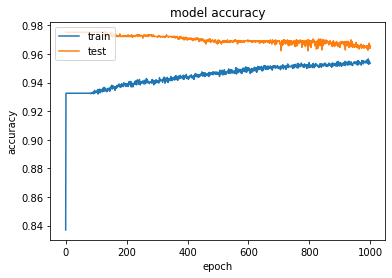

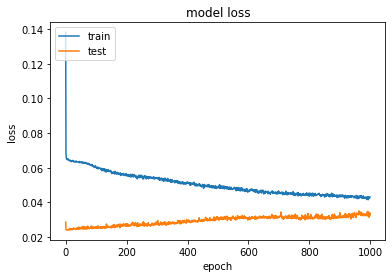

In [ ]:
## summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
_loss, _acc, _precision, _recall, _f1score = model.evaluate(now_x, now_y, batch_size=batch_size, verbose=0)
print('loss: {:.4f}, accuracy: {:.4f}, precision: {:.4f}, recall: {:.4f}, f1score: {:.4f}'.format(_loss, _acc, _precision, _recall, _f1score))

loss: 0.0326, accuracy: 0.9652, precision: 0.9660, recall: 0.9660, f1score: 0.9660


In [ ]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import matplotlib as mpl
import matplotlib.pyplot as plt

y_pred_keras = model.predict(now_x)
print(y_pred_keras)
#ROC (Receiver Operating Characteristic)  AUC (Area Under Curve, 곡선 아래 면적)
score = roc_auc_score(now_y, y_pred_keras) 
print(score)

[[9.7384399e-01 2.6196957e-02]
 [9.7209728e-01 2.7946025e-02]
 [8.9160109e-01 1.0845992e-01]
 ...
 [9.7551179e-01 2.4526834e-02]
 [6.0603023e-04 9.9939424e-01]
 [9.5720410e-01 4.2837083e-02]]
0.5047196227249282


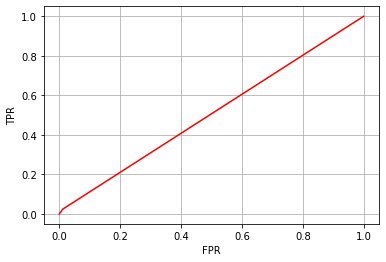

In [ ]:
fprs, tprs, thresholds = metrics.roc_curve(now_y.idxmax(axis=1), y_pred_keras.argmax(axis=1))
plt.figure()
plt.plot([0,0],[1,1], label='STR',  color='green', linestyle='--')
plt.plot(fprs, tprs, label='ROC', color='red')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.show()

In [ ]:
#For fundsimulation using vali data 
new_funsim = []
new_code = []
new_date = []
new_zero = []
#vali_code_arr.append(code)
#vali_date_arr.append(date)
pred_funsim = model.predict(vali_x)
print(pred_funsim.argmax(axis=1))
for i in range(len(pred_funsim)):
    if pred_funsim[i][0] < pred_funsim[i][1]:
        new_funsim.append(pred_funsim[i][1])
        new_date.append(vali_date_arr[i])
        new_code.append(vali_code_arr[i])
        new_zero.append(0.0)


[0 0 0 ... 0 0 0]


In [ ]:
funsim_code = pd.DataFrame(new_code, columns=['code'])
funsim_date = pd.DataFrame(new_date, columns=['date'])
funsim_rate = pd.DataFrame(new_funsim, columns=['rate'])
funsim_zero = pd.DataFrame(new_zero, columns=['zero'])
funsim_code = funsim_code.astype(str)
funsim_date = funsim_date.astype(int)
pred_funsimDataframe = pd.concat([funsim_code, funsim_date, funsim_rate, funsim_zero], axis=1)

In [ ]:
pred_funsimDataframe['code'] = pred_funsimDataframe['code'].str.zfill(width=8)
pred_funsimDataframe['code'] = pred_funsimDataframe['code'].str.replace(pat='.0', repl='', regex=False)

In [ ]:
pred_funsimDataframe = pred_funsimDataframe.sort_values(by='date')

In [ ]:
pred_funsimDataframe.to_csv('hivol-예측치_date.txt', sep = ',', index = False)